Pretrain BERT for sentiment analysis

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [11]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [13]:
tokens = tokenizer.encode('It was good but couldve been better. Great', return_tensors='pt')

In [14]:
result = model(tokens)

In [15]:
result.logits

tensor([[-2.7768, -1.2353,  1.4419,  1.9804,  0.4584]],
       grad_fn=<AddmmBackward0>)

In [16]:
int(torch.argmax(result.logits))+1

4

In [17]:
r = requests.get('https://www.yelp.com/biz/social-brew-cafe-pyrmont')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

In [ ]:
reviews

In [19]:
import numpy as np
import pandas as pd
df = pd.DataFrame(np.array(reviews), columns=['review'])

In [20]:
df.head()

,review
0,Very cute coffee shop and restaurant. They hav...
1,Six of us met here for breakfast before our wa...
2,Great place with delicious food and friendly s...
3,Some of the best Milkshakes me and my daughter...
4,Great food amazing coffee and tea. Short walk ...


In [21]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [22]:
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [23]:
df.head()

,review,sentiment
0,Very cute coffee shop and restaurant. They hav...,4
1,Six of us met here for breakfast before our wa...,4
2,Great place with delicious food and friendly s...,5
3,Some of the best Milkshakes me and my daughter...,5
4,Great food amazing coffee and tea. Short walk ...,5


In [32]:
counts = df['sentiment'].value_counts()
counts

5    6
4    3
3    1
Name: sentiment, dtype: int64

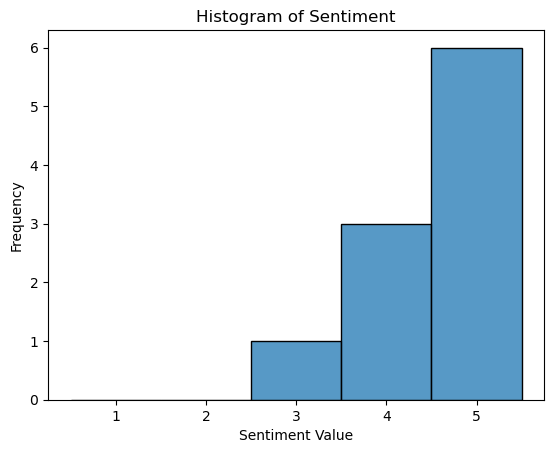

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
sns.histplot(df['sentiment'], bins=bins, kde=False)
plt.title('Histogram of Sentiment')
plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.show()

N-grams

In [12]:
import nltk
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
nltk.download('brown')
corpus = brown.words()

lower_case_corpus = [w.lower() for w in corpus]
vocab = set(lower_case_corpus)

print('CORPUS EXAMPLE: ' + str(lower_case_corpus[:100]) + '\n\n')
print('VOCAB EXAMPLE: ' + str(list(vocab)[:10]))

[nltk_data] Downloading package brown to
[nltk_data]     /Users/lijiazheng/nltk_data...
[nltk_data]   Package brown is already up-to-date!


CORPUS EXAMPLE: ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', "atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.', 'the', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'city', 'executive', 'committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'city', 'of', 'atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.', 'the', 'september-october', 'term', 'jury', 'had', 'been', 'charged', 'by', 'fulton', 'superior', 'court', 'judge', 'durwood', 'pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'mayor-nominate', 'ivan']


VOCAB EXAMPLE: ['source', 'aggravates', 'brain', 'drawers', 'vue', 'di

In [5]:
print('Total words in Corpus: ' + str(len(lower_case_corpus)))
print('Vocab of the Corpus: ' + str(len(vocab)))

Total words in Corpus: 1161192
Vocab of the Corpus: 49815


In [6]:
bigram_counts = {}
trigram_counts = {}

# Sliding through corpus to get bigram and trigram counts
for i in range(len(lower_case_corpus) - 2):
    # Getting bigram and trigram at each slide
    bigram = (lower_case_corpus[i], lower_case_corpus[i+1])
    trigram = (lower_case_corpus[i], lower_case_corpus[i+1], lower_case_corpus[i+2])
    
    # Keeping track of the bigram counts
    if bigram in bigram_counts.keys():
        bigram_counts[bigram] += 1
    else:
        bigram_counts[bigram] = 1
 
    # Keeping track of trigram counts
    if trigram in trigram_counts.keys():
        trigram_counts[trigram] += 1
    else:
        trigram_counts[trigram] = 1

print("Example, count for bigram ('the', 'king') is: " + str(bigram_counts[('the', 'king')]))

Example, count for bigram ('the', 'king') is: 51


In [7]:
def suggest_next_word(input_, bigram_counts, trigram_counts, vocab):
    # Consider the last bigram of sentence
    tokenized_input = word_tokenize(input_.lower())
    last_bigram = tokenized_input[-2:]
    
    # Calculating probability for each word in vocab
    vocab_probabilities = {}
    for vocab_word in vocab:
        test_trigram = (last_bigram[0], last_bigram[1], vocab_word)
        test_bigram = (last_bigram[0], last_bigram[1])

        test_trigram_count = trigram_counts.get(test_trigram, 0)
        test_bigram_count = bigram_counts.get(test_bigram, 0)
        
        probability = test_trigram_count / test_bigram_count
        vocab_probabilities[vocab_word] = probability
    
    # Sorting the vocab probability in descending order to get top probable words
    top_suggestions = sorted(vocab_probabilities.items(), key=lambda x: x[1], reverse=True)[:3]
    return top_suggestions

In [8]:
suggest_next_word('I am the king', bigram_counts, trigram_counts, vocab)

[('james', 0.17647058823529413),
 ('of', 0.1568627450980392),
 ('arthur', 0.11764705882352941)]

In [9]:
suggest_next_word('I am the king of', bigram_counts, trigram_counts, vocab)

[('france', 0.3333333333333333),
 ('hearts', 0.16666666666666666),
 ('kings', 0.08333333333333333)]

In [27]:
import nltk
from nltk.corpus import brown
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('brown')
nltk.download('punkt')

sentences = [' '.join(sent) for sent in brown.sents()]

# Create a TfidfVectorizer object
tfidf_vect = TfidfVectorizer()

tfidf_matrix = tfidf_vect.fit_transform(sentences)
words = tfidf_vect.get_feature_names_out()

sentence_idx = 100
tfidf_scores = tfidf_matrix[sentence_idx].todense().tolist()[0]
word_scores = list(zip(words, tfidf_scores))

# Sort words by their TF-IDF scores in descending order
sorted_word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)

print("the top 10 TF-IDF scores in the 100th sentence:",sorted_word_scores[:10])

[nltk_data] Downloading package brown to
[nltk_data]     /Users/lijiazheng/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lijiazheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


the top 10 TF-IDF scores in the 100th sentence: [('legislatures', 0.3023731845268359), ('watered', 0.2750594872690913), ('taxation', 0.26376827508568723), ('rejection', 0.26153928132518095), ('daniel', 0.25406878501554947), ('revenue', 0.2347663302949751), ('personally', 0.22758641981199595), ('considerably', 0.22696060570686474), ('hearing', 0.21348804315473366), ('previous', 0.2086022263349752)]


Visualization

[nltk_data] Downloading package brown to
[nltk_data]     /Users/lijiazheng/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lijiazheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


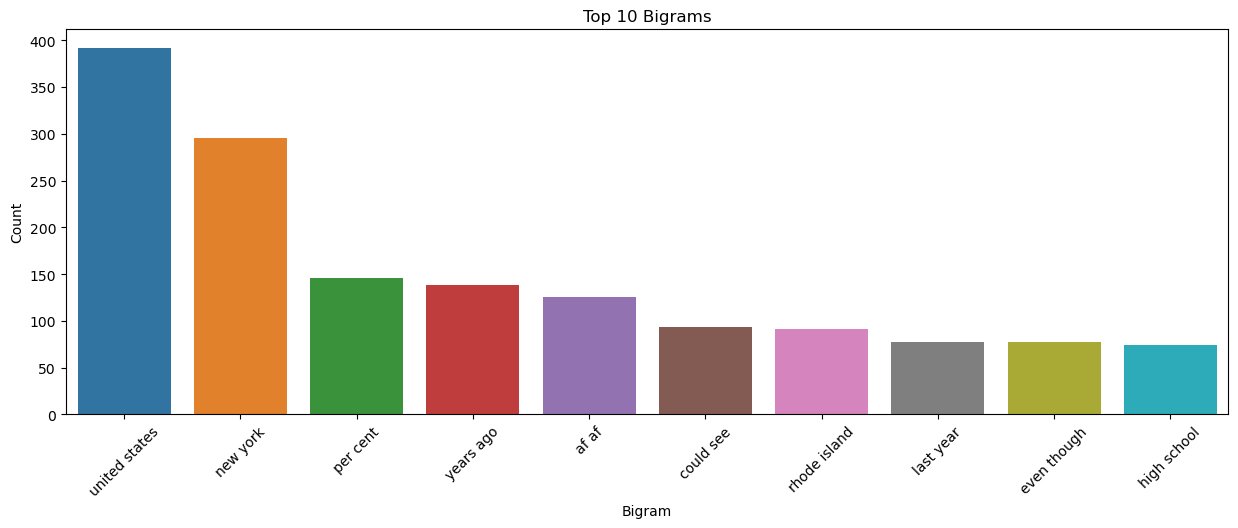

In [22]:
import string
from nltk.corpus import brown
from nltk import bigrams
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

nltk.download('brown')
nltk.download('stopwords')

corpus = brown.words()

# Adding extra punctuation to the standard list
extra_punctuations = ['``', "''", '--']
all_punctuations = set(string.punctuation).union(extra_punctuations)

# Convert to lower case and filter out stopwords and all punctuation
stop_words = set(nltk.corpus.stopwords.words('english'))
lower_case_corpus = [
    w.lower() for w in corpus
    if w.lower() not in stop_words and w not in all_punctuations
]

# Create bigrams from the filtered corpus
filtered_bigrams = list(bigrams(lower_case_corpus))

# Count the bigrams in the filtered corpus
filtered_bigram_counts = {}
for bg in filtered_bigrams:
    if bg in filtered_bigram_counts:
        filtered_bigram_counts[bg] += 1
    else:
        filtered_bigram_counts[bg] = 1

# Get the top 10 bigrams after removing stopwords and all punctuation
top_filtered_bigrams = dict(sorted(filtered_bigram_counts.items(), key=lambda item: item[1], reverse=True)[:10])

# Create a DataFrame for visualization
bigram_df = pd.DataFrame(list(top_filtered_bigrams.items()), columns=['Bigram', 'Count'])

# Visualize the top 10 bigrams after removing stopwords and all punctuation
plt.figure(figsize=(15, 5))
# Convert bigram tuples to strings for plotting
bigram_df['Bigram'] = bigram_df['Bigram'].apply(lambda x: ' '.join(x))
sns.barplot(x='Bigram', y='Count', data=bigram_df)
plt.xticks(rotation=45)
plt.title('Top 10 Bigrams')
plt.show()


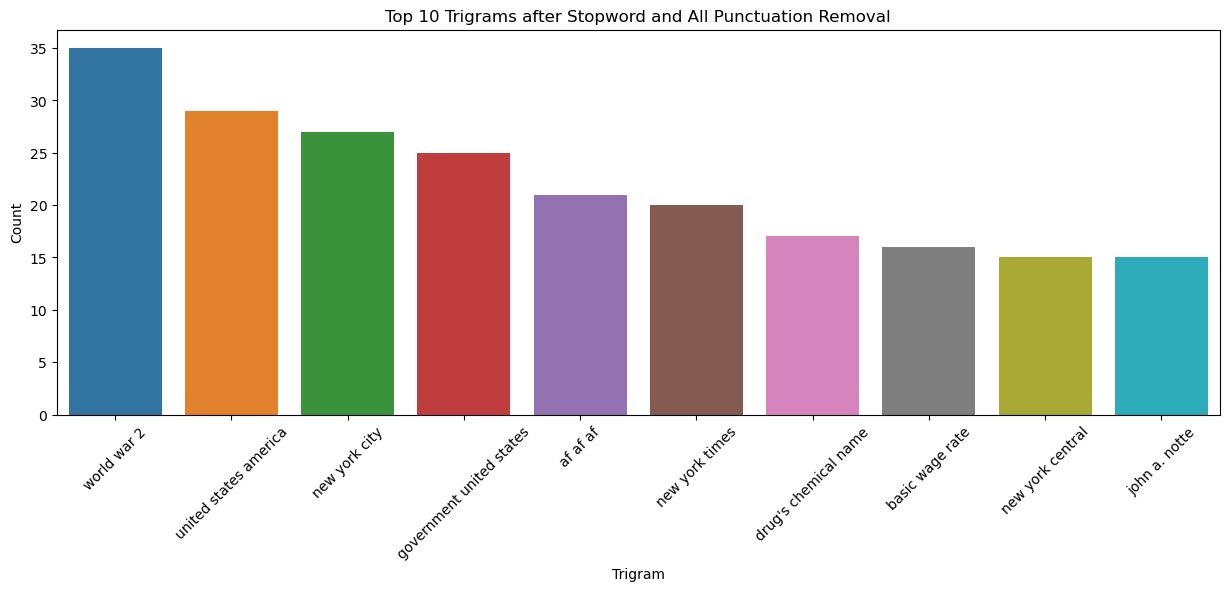

In [24]:
from nltk import trigrams
filtered_trigrams = list(trigrams(lower_case_corpus))

# Count the trigrams in the filtered corpus
filtered_trigram_counts = {}
for tg in filtered_trigrams:
    if tg in filtered_trigram_counts:
        filtered_trigram_counts[tg] += 1
    else:
        filtered_trigram_counts[tg] = 1

# Get the top 10 trigrams after removing stopwords and all punctuation
top_filtered_trigrams = dict(sorted(filtered_trigram_counts.items(), key=lambda item: item[1], reverse=True)[:10])

# Create a DataFrame for visualization
trigram_df = pd.DataFrame(list(top_filtered_trigrams.items()), columns=['Trigram', 'Count'])

# Visualize the top 10 trigrams after removing stopwords and all punctuation
plt.figure(figsize=(15, 5))
# Convert trigram tuples to strings for plotting
trigram_df['Trigram'] = trigram_df['Trigram'].apply(lambda x: ' '.join(x))
sns.barplot(x='Trigram', y='Count', data=trigram_df)
plt.xticks(rotation=45)
plt.title('Top 10 Trigrams after Stopword and All Punctuation Removal')
plt.show()

CBOW word2vec

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Hyperparameters
embedding_dim = 5  # Typically, a larger number like 100, 200, or 300 is used
context_size = 2   # Number of words left/right of the target word

word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for word, i in word_to_ix.items()}
vocab_size = len(vocab)

# Define the window size for the context
window_size = 2  # This is an arbitrary choice; you can choose other sizes

In [ ]:
def generate_context_pairs(corpus, word_to_ix, window_size):
    data = []
    for i, word in enumerate(corpus):
        start = max(0, i - window_size)
        end = min(len(corpus), i + window_size + 1)
        context = [corpus[j] for j in range(start, end) if j != i]
        target = word_to_ix[word]
        context_indices = [word_to_ix[w] for w in context]
        data.append((context_indices, target))
    return data

data = generate_context_pairs(lower_case_corpus, word_to_ix, window_size)

def pad_context(context_indices, context_size):
    return context_indices + [0] * (2 * context_size - len(context_indices))

# Define the CBOW model
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs).mean(dim=1)  # Corrected dimension
        out = self.linear(embeds)
        log_probs = nn.functional.log_softmax(out, dim=1)  # Corrected dimension
        return log_probs
    

model = CBOW(vocab_size, embedding_dim, context_size).to(device)  # Move model to GPU if available
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

# Training loop
for epoch in range(100):
    total_loss = 0
    for context, target in data_loader:  # Your DataLoader should handle batching
        context, target = context.to(device), target.to(device)  # Move data to GPU if available
        model.zero_grad()
        log_probs = model(context)
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Print loss every 10 epochs or adjust to your preference
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Total Loss: {total_loss:.2f}')


Epoch 0: Total Loss: 9806125.42


In [ ]:
word_indices = torch.tensor([quick_idx, brown_idx], dtype=torch.long)
embeddings = model.embeddings(word_indices)
print(f"Embedding for 'quick': {embeddings[0]}")
print(f"Embedding for 'brown': {embeddings[1]}")

In [ ]:
# def predict_next_word(model, context, word_to_ix, ix_to_word):
#     # Check if the context is less than the expected size and pad it if necessary
#     if len(context) < 2 * context_size:
#         context = [0] * (2 * context_size - len(context)) + context
#     # Otherwise, take the last `2 * context_size` words as the context
#     else:
#         context = context[-(2 * context_size):]

#     # Convert context words to indices, handling out-of-vocabulary words
#     context_indices = [word_to_ix.get(w, 0) for w in context]  # 0 is typically for unknown words

#     # Transform to a PyTorch tensor and add a batch dimension
#     context_var = torch.tensor([context_indices], dtype=torch.long)

#     # Get the log probabilities from the model
#     with torch.no_grad():
#         log_probs = model(context_var)

#     # Convert log probabilities to probabilities
#     probs = torch.exp(log_probs)

#     # Get the index of the highest probability
#     _, predicted_index = torch.max(probs, 1)

#     # Convert index to word
#     predicted_word = ix_to_word[predicted_index.item()]

#     return predicted_word

# # Example usage:
# context = ['i', 'am', 'the', 'king', 'of']
# predicted_word = predict_next_word(model, context, word_to_ix, ix_to_word)
# print(f"The next word is: {predicted_word}")
